In [545]:
import pandas as pd

from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
import umap
from torch.utils.data import DataLoader
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import bamboolib
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [59]:
def wrap_by_word(string, n_words):
    """returns a string where \\n is inserted between every n words"""
    a = string.split()
    ret = ""
    for i in range(0, len(a), n_words):
        ret += " ".join(a[i : i + n_words]) + "<br>"

    return ret

In [535]:
data = pd.read_csv(
    "/Users/charlesdedampierre/Desktop/ENS Projects/imaginary-world/db_film_iw (2).csv",
    index_col=[0],
)

data = data.sample(5000)


text_var = 'description'
data = data[data[text_var].notna()]
data['text_prep'] = data[text_var].apply(lambda x: wrap_by_word(x, 10))
X = data[text_var].to_list()

model_tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = model_tfidf.fit_transform(X)
tfidf_features = model_tfidf.get_feature_names()

In [544]:
scaler = MinMaxScaler(feature_range = (-1, 1))

In [575]:
pca = PCA(n_components=4)
emb_red = pca.fit_transform(X_tfidf.todense())
emb_red = scaler.fit_transform(emb_red)


res = pd.DataFrame(emb_red, columns = ['pca_1', 'pca_2', 'pca_3', 'pca_4'])
res['text'] = data['text_prep'].tolist()

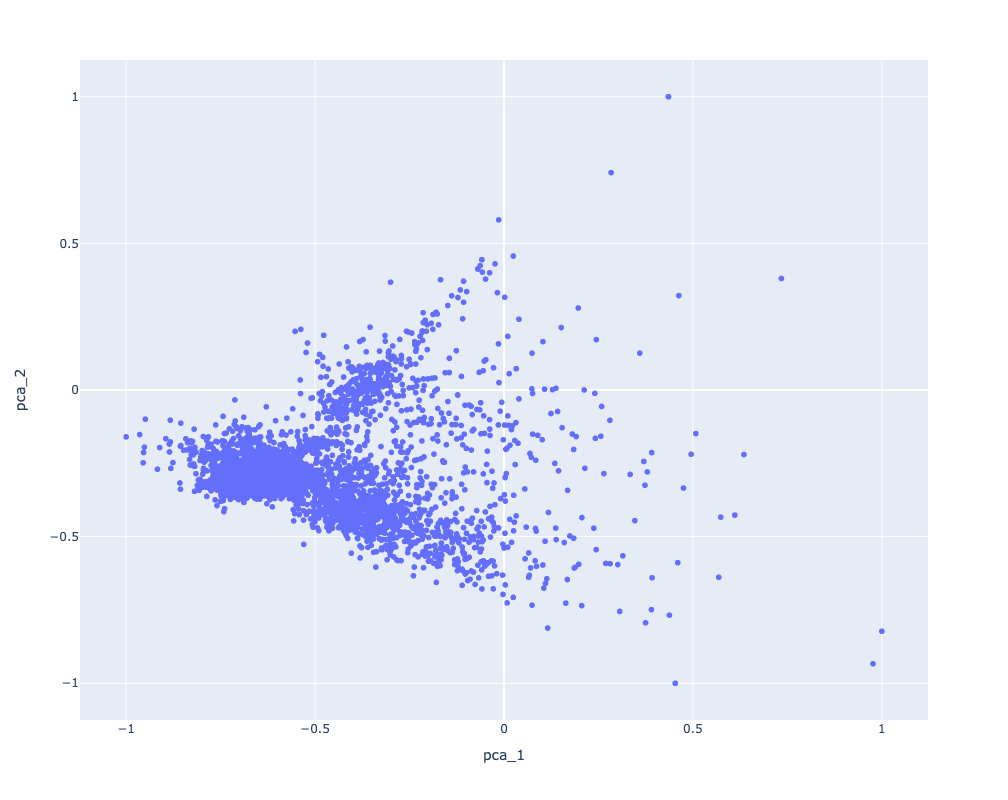

In [579]:
fig_pca = px.scatter(res, x = 'pca_1', y='pca_2',  hover_data = ['text'], height = 800)
fig_pca.show()

In [63]:
#### Project the terms

In [580]:
df_X_tfidf = pd.DataFrame(X_tfidf.todense(), columns = tfidf_features)
X_terms = df_X_tfidf.T

"""
pca = PCA(n_components=2)
emb_red = pca.fit_transform(X_terms)

res = pd.DataFrame(emb_red, columns = ['dim_1', 'dim_2'])
res['text'] = X_terms.index.tolist()

px.scatter(res, x = 'dim_1', y='dim_2',  hover_data = ['text'], height = 800)

from mlxtend.data import iris_data
from mlxtend.plotting import plot_pca_correlation_graph
import numpy as np


figure, correlation_matrix = plot_pca_correlation_graph(X_tfidf.todense(), 
                                                        tfidf_features,
                                                        dimensions=(1, 2),
                                                        figure_axis_size=5)

"""

"\npca = PCA(n_components=2)\nemb_red = pca.fit_transform(X_terms)\n\nres = pd.DataFrame(emb_red, columns = ['dim_1', 'dim_2'])\nres['text'] = X_terms.index.tolist()\n\npx.scatter(res, x = 'dim_1', y='dim_2',  hover_data = ['text'], height = 800)\n\nfrom mlxtend.data import iris_data\nfrom mlxtend.plotting import plot_pca_correlation_graph\nimport numpy as np\n\n\nfigure, correlation_matrix = plot_pca_correlation_graph(X_tfidf.todense(), \n                                                        tfidf_features,\n                                                        dimensions=(1, 2),\n                                                        figure_axis_size=5)\n\n"

In [581]:
def corr2_coeff(A, B):
    """
    Compute correlation coefficients and return as a np array
    """
    A, B = np.array(A), np.array(B)
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))



def create_correlation_table(A, B, names_cols_A, names_cols_B):
    """
    Compute correlation coefficients and return as a DataFrame.

    A and B: 2d array like.
        The columns represent the different variables and the rows are
        the samples of thos variables
    names_cols_A/B : name to be added to the final pandas table

    return: pandas DataFrame with the corelations.Columns and Indexes
    represent the different variables of A and B (respectvely)
    """
    # corrs = np.corrcoef(np.transpose(A), np.transpose(B)
    #                     )[len(names_cols_A):, :len(names_cols_A)]
    corrs = corr2_coeff(A.T, B.T).T

    df_corrs = pd.DataFrame(corrs,
                            columns=names_cols_A, index=names_cols_B)
    return df_corrs


In [584]:
'''

n_comp = 4
variables_names =  tfidf_features.copy()
corrs = create_correlation_table(X_pca, X, ['dim ' + str(i + 1) for i in range(n_comp)], variables_names)
corrs = corrs.reset_index()
corrs.columns = ['terms', 'pca_1', 'pca_2']
corrs = corrs.melt('terms')
corrs.columns = ['terms', 'dimension', 'corr']
df_corr = corrs.sort_values(['dimension', 'corr'], ascending = (True, False)).reset_index(drop=True)

scaler = MinMaxScaler(feature_range = (-1, 1))
df_corr['corr_norm'] = scaler.fit_transform(df_corr['corr'].array.reshape(-1, 1))  


'''

"\n\nn_comp = 4\nvariables_names =  tfidf_features.copy()\ncorrs = create_correlation_table(X_pca, X, ['dim ' + str(i + 1) for i in range(n_comp)], variables_names)\ncorrs = corrs.reset_index()\ncorrs.columns = ['terms', 'pca_1', 'pca_2']\ncorrs = corrs.melt('terms')\ncorrs.columns = ['terms', 'dimension', 'corr']\ndf_corr = corrs.sort_values(['dimension', 'corr'], ascending = (True, False)).reset_index(drop=True)\n\nscaler = MinMaxScaler(feature_range = (-1, 1))\ndf_corr['corr_norm'] = scaler.fit_transform(df_corr['corr'].array.reshape(-1, 1))  \n\n\n"

In [585]:
"""

final = pd.concat([res.reset_index(drop=True), df_X_tfidf.reset_index(drop=True)], axis=1)
final = final.drop('text', axis = 1)


df_corr = pd.DataFrame()
for dim in ['dim_1', 'dim_2', 'dim_3']:
    for term in final.iloc[:, 3:].columns.to_list():
        corr = np.corrcoef(final[dim], final[term])[0][1]
        dict = {'dimension':dim, 'terms':term, 'corr':corr}
        res_corr = pd.DataFrame(dict, index = [0])
        df_corr = df_corr.append(res_corr)
        
df_corr = df_corr.sort_values(['dimension', 'corr'], ascending = (True, False)).reset_index(drop=True)

"""

"\n\nfinal = pd.concat([res.reset_index(drop=True), df_X_tfidf.reset_index(drop=True)], axis=1)\nfinal = final.drop('text', axis = 1)\n\n\ndf_corr = pd.DataFrame()\nfor dim in ['dim_1', 'dim_2', 'dim_3']:\n    for term in final.iloc[:, 3:].columns.to_list():\n        corr = np.corrcoef(final[dim], final[term])[0][1]\n        dict = {'dimension':dim, 'terms':term, 'corr':corr}\n        res_corr = pd.DataFrame(dict, index = [0])\n        df_corr = df_corr.append(res_corr)\n        \ndf_corr = df_corr.sort_values(['dimension', 'corr'], ascending = (True, False)).reset_index(drop=True)\n\n"

In [147]:

# mlxtend Machine Learning Library Extensions
#
# A function for plotting a PCA correlation circle
# File Author: Gabriel Azevedo Ferreira <az.fe.gabriel@gmail.com>

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.externals.adjust_text import adjust_text
from mlxtend.feature_extraction import PrincipalComponentAnalysis


def corr2_coeff(A, B):
    """
    Compute correlation coefficients and return as a np array
    """
    A, B = np.array(A), np.array(B)
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))




def plot_pca_correlation_graph(X, variables_names, dimensions=(1, 2),
                               figure_axis_size=6, X_pca=None,
                               explained_variance=None):
   
    X = np.array(X)
    X = X - X.mean(axis=0)
    n_comp = max(dimensions)

    if (X_pca is None) and (explained_variance is None):
        pca = PrincipalComponentAnalysis(n_components=n_comp)
        pca.fit(X)
        X_pca = pca.transform(X)
        explained_variance = pca.e_vals_


    corrs = create_correlation_table(X_pca, X, ['Dim ' + str(i + 1) for i in
                                                range(n_comp)],
                                     variables_names)
    tot = sum(X.var(0)) * X.shape[0] / (X.shape[0] - 1)
    explained_var_ratio = [(i / tot) * 100 for i in explained_variance]

    # Plotting circle
    fig_res = plt.figure(figsize=(figure_axis_size, figure_axis_size))
    plt.Circle((0, 0), radius=1, color='k', fill=False)
    circle1 = plt.Circle((0, 0), radius=1, color='k', fill=False)
    fig = plt.gcf()
    fig.gca().add_artist(circle1)

    # Plotting arrows
    texts = []
    for name, row in corrs.iterrows():
        x = row['Dim ' + str(dimensions[0])]
        y = row['Dim ' + str(dimensions[1])]
        plt.arrow(0.0, 0.0, x, y, color='k', length_includes_head=True,
                  head_width=.05)

        plt.plot([0.0, x], [0.0, y], 'k-')
        texts.append(plt.text(x, y, name, fontsize=2 * figure_axis_size))
    # Plotting vertical lines
    plt.plot([-1.1, 1.1], [0, 0], 'k--')
    plt.plot([0, 0], [-1.1, 1.1], 'k--')

    # Adjusting text
    adjust_text(texts)
    # Setting limits and title
    plt.xlim((-1.1, 1.1))
    plt.ylim((-1.1, 1.1))
    plt.title("Correlation Circle", fontsize=figure_axis_size * 3)

    plt.xlabel("Dim " + str(dimensions[0]) + " (%s%%)" %
               str(explained_var_ratio[dimensions[0] - 1])[:4],
               fontsize=figure_axis_size * 2)
    plt.ylabel("Dim " + str(dimensions[1]) + " (%s%%)" %
               str(explained_var_ratio[dimensions[1] - 1])[:4],
               fontsize=figure_axis_size * 2)
    return fig_res, corrs


In [149]:
#X_tfidf = model_tfidf.fit_transform(X)
#tfidf_features = model_tfidf.get_feature_names()


In [194]:
from mlxtend.externals.adjust_text import adjust_text

In [460]:
data = pd.read_csv(
    "/Users/charlesdedampierre/Desktop/ENS Projects/imaginary-world/db_film_iw (2).csv",
    index_col=[0],
)

data = data.sample(5000)


text_var = 'description'
data = data[data[text_var].notna()]
data['text_prep'] = data[text_var].apply(lambda x: wrap_by_word(x, 10))
X = data[text_var].to_list()

model_tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
X_tfidf = model_tfidf.fit_transform(X)

In [603]:
# Take some time

n_components = 4

X = np.array(X_tfidf.todense())
X = X - X.mean(axis=0)
pca = PrincipalComponentAnalysis(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)


In [607]:
explained_variance = pca.e_vals_
explained_variance = [str(round(x*100, 2)) + '%' for x in explained_variance]

In [654]:
tfidf_features = model_tfidf.get_feature_names()
variables_names = tfidf_features.copy()

corrs = create_correlation_table(X_pca, X, ['pca_' + str(i + 1) for i in range(n_components)], variables_names)
tot = sum(X.var(0)) * X.shape[0] / (X.shape[0] - 1)
#explained_var_ratio = [(i / tot) * 100 for i in explained_variance]

# Filter the top 20

top_n = 5

corrs_top = corrs.reset_index()
corrs_top = corrs_top.rename({'index':'terms'}, axis=1)
corrs_top = corrs_top.melt('terms')
corrs_top.columns = ['terms', 'dimension', 'corr']
corrs_top = corrs_top.sort_values(['dimension', 'corr'], ascending = (True, False)).reset_index(drop=True)

# Rescale from -1 to 1
scaler = MinMaxScaler(feature_range = (-1, 1))
corrs_top['corr'] = scaler.fit_transform(corrs_top['corr'].array.reshape(-1, 1)) 

corrs_top["rank"] = corrs_top.groupby(['dimension'])["corr"].rank(
        method="first", ascending=False
    )
corrs_top_rank = corrs_top[corrs_top['rank']<=10]


'''
df_top_corrs = corrs_top.groupby('dimension').head(top_n)
df_minus_corrs = corrs_top.groupby('dimension').tail(top_n)
df_corrs = pd.concat([df_top_corrs, df_minus_corrs]).reset_index(drop=True)

# filter the terms
terms_to_keep  = df_corrs['terms'].to_list()
'''

terms_to_keep  = corrs_top_rank['terms'].to_list()
df_corrs = corrs_top[corrs_top['terms'].isin(terms_to_keep)]
corrs_filtered = df_corrs.pivot(index= 'terms', columns = 'dimension', values = 'corr')

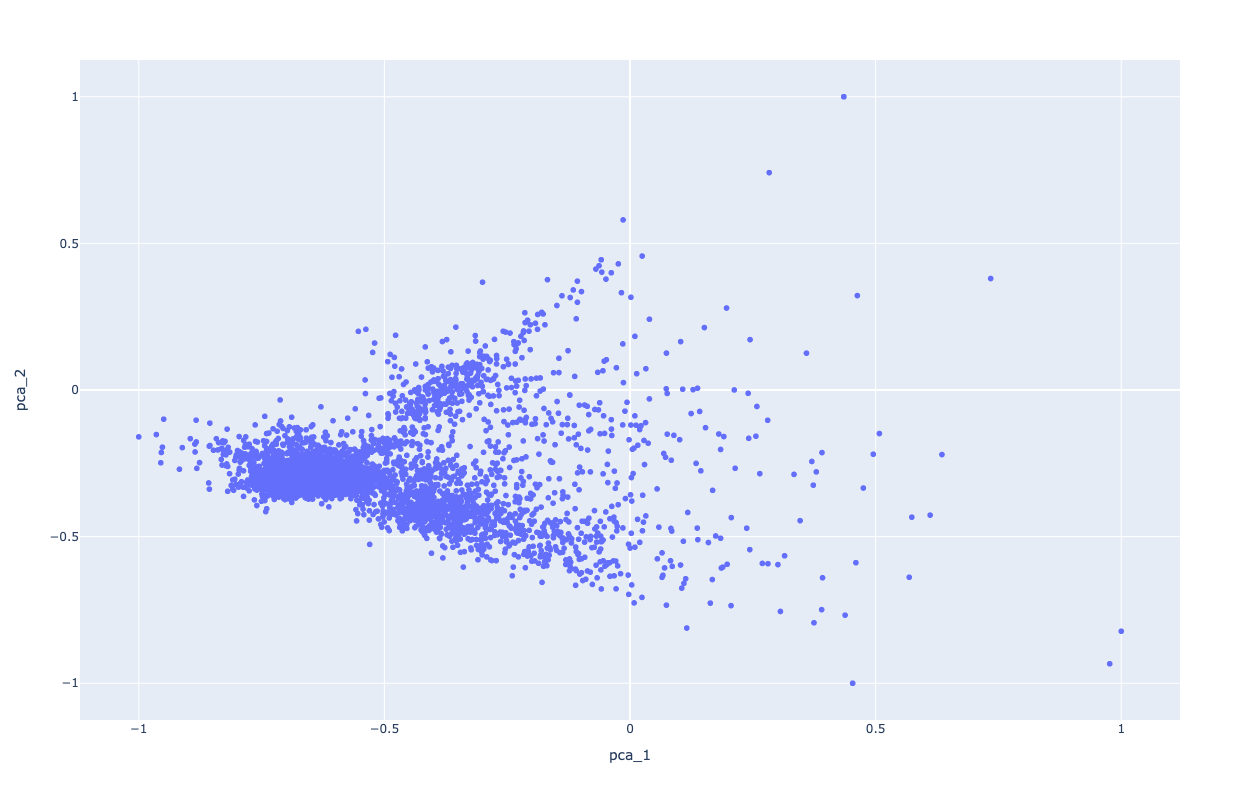

In [660]:
fig_pca.show()

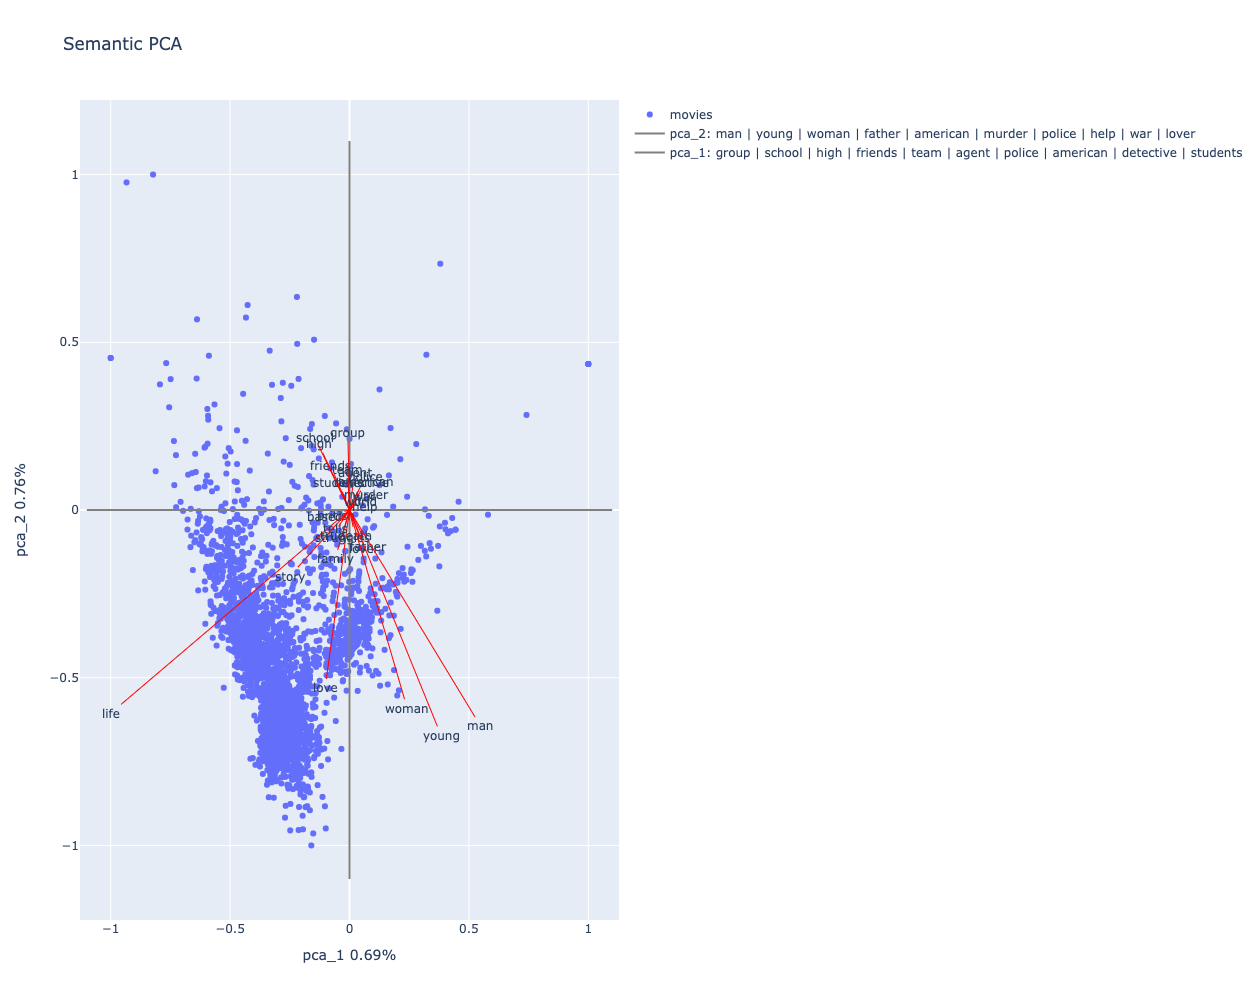

In [663]:
enter_dim = ['pca_2', 'pca_1']

mask_1 = corrs_top_rank['dimension'] == enter_dim[0]
legend_1 = corrs_top_rank[mask_1]['terms'].tolist()
legend_1 = ' | '.join(legend_1)

mask_2 = corrs_top_rank['dimension'] == enter_dim[1]
legend_2 = corrs_top_rank[mask_2]['terms'].tolist()
legend_2 = ' | '.join(legend_2)



def make_edge(x, y, text, width):
    return go.Scatter(
        x=x,
        y=y,
        hoverinfo="text",
        mode="lines",
    )

fig = go.Figure()

texts = []
for name, row in corrs_filtered.iterrows():
    x = row[enter_dim[0]]
    y = row[enter_dim[1]]
        
    trace = make_edge(x=[0.0, x, None], y = [0.0, y, None], text = name, width = 0.2)
    
    
    #fig.add_trace(trace)
    
    
    fig.add_annotation(
          x=0.0,  # arrows' head
          y=0.0,  # arrows' head
          ax=x,  # arrows' tail
          ay=y,  # arrows' tail
          xref='x',
          yref='y',
          axref='x',
          ayref='y',
          text=name,  # if you want only the arrow
          arrowcolor = 'red'
          #showarrow=True,
          #arrowhead=0,
          #arrowsize=0.3,
          #arrowwidth=0.3,
          #arrowcolor='black'
        )

trace_1 = go.Scatter(
    x=[-1.1, 1.1],
    y=[0, 0],
    mode="lines",
    line_color="grey",
    name = enter_dim[0] + ': '+ legend_1)



trace_2 = go.Scatter(
    x=[0, 0],
    y=[-1.1, 1.1],
    mode="lines",
    line_color="grey",
    name = enter_dim[1] + ': '+ legend_2)

trace_scatter = go.Scatter(
    x=res[enter_dim[0]],
    y=res[enter_dim[1]],
    text = res['text'],
    mode="markers",
    hoverinfo ='text',
    name = 'movies')

fig.add_trace(trace_scatter)
fig.add_trace(trace_1)
fig.add_trace(trace_2)


fig.update_layout(
        title='Semantic PCA',
        height=1000,
        width=1000,
        xaxis_title=f"{enter_dim[1]} {explained_variance[1]}",
        yaxis_title=f"{enter_dim[0]} {explained_variance[0]}",
    )

fig.show()

In [431]:
"""

# Plotting circle
fig_res = plt.figure(figsize=(figure_axis_size, figure_axis_size))
#plt.Circle((0, 0), radius=1, color='k', fill=False)

#circle1 = plt.Circle((0, 0), radius=1, color='k', fill=False)
#fig = plt.gcf()
#fig.gca().add_artist(circle1)

# Plotting arrows
texts = []
for name, row in corrs_2.iterrows():
    x = row['Dim ' + str(dimensions[0])]
    y = row['Dim ' + str(dimensions[1])]
    plt.arrow(0.0, 0.0, x, y, color='k', length_includes_head=False,
              head_width=.03)

    plt.plot([0.0, x], [0.0, y], 'k-')
    texts.append(plt.text(x, y, name, fontsize=2 * figure_axis_size))
# Plotting vertical lines
plt.plot([-1.1, 1.1], [0, 0], 'k--')
plt.plot([0, 0], [-1.1, 1.1], 'k--')

adjust_text(texts)



plt.xlim((-1.1, 1.1))
plt.ylim((-1.1, 1.1))
plt.title("Correlation Circle", fontsize=figure_axis_size * 3)

plt.xlabel("Dim " + str(dimensions[0]) + " (%s%%)" %
           str(explained_var_ratio[dimensions[0] - 1])[:4],
           fontsize=figure_axis_size * 2)
plt.ylabel("Dim " + str(dimensions[1]) + " (%s%%)" %
           str(explained_var_ratio[dimensions[1] - 1])[:4],
           fontsize=figure_axis_size * 2)
           
"""

'\n\n# Plotting circle\nfig_res = plt.figure(figsize=(figure_axis_size, figure_axis_size))\n#plt.Circle((0, 0), radius=1, color=\'k\', fill=False)\n\n#circle1 = plt.Circle((0, 0), radius=1, color=\'k\', fill=False)\n#fig = plt.gcf()\n#fig.gca().add_artist(circle1)\n\n# Plotting arrows\ntexts = []\nfor name, row in corrs_2.iterrows():\n    x = row[\'Dim \' + str(dimensions[0])]\n    y = row[\'Dim \' + str(dimensions[1])]\n    plt.arrow(0.0, 0.0, x, y, color=\'k\', length_includes_head=False,\n              head_width=.03)\n\n    plt.plot([0.0, x], [0.0, y], \'k-\')\n    texts.append(plt.text(x, y, name, fontsize=2 * figure_axis_size))\n# Plotting vertical lines\nplt.plot([-1.1, 1.1], [0, 0], \'k--\')\nplt.plot([0, 0], [-1.1, 1.1], \'k--\')\n\nadjust_text(texts)\n\n\n\nplt.xlim((-1.1, 1.1))\nplt.ylim((-1.1, 1.1))\nplt.title("Correlation Circle", fontsize=figure_axis_size * 3)\n\nplt.xlabel("Dim " + str(dimensions[0]) + " (%s%%)" %\n           str(explained_var_ratio[dimensions[0] - 1])[: